# Introduction

Here're several notebooks that really give me great inspiration. I really recommend you to take a look!
- [NYCT - from A to Z with XGBoost (Tutorial)](https://www.kaggle.com/karelrv/nyct-from-a-to-z-with-xgboost-tutorial/notebook)
    - This is by far my favorite kernel.
- [From EDA to the Top (LB 0.367)](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367)

## Problem description
In this competition, we want to build a model to make prediction on the total ride duration of taxi trips in New York City.<br>
Data fields:
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

## Observation
After scanning through the data fields, we can know that we have to deal with not only categorical and numerical data, but also time series and location data. And we may want to eliminate store_and_fwd_flag since it doesn't look like a feature that will contribute to the prediction.
We'll deal with all the data step by step.
Before we go any further, let's import some packages that we're going to use later.

In [555]:
%matplotlib inline
from IPython.core.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import operator
import folium
import gpxpy.geo
import time
from scipy.stats import skew
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from sklearn.decomposition import PCA
output_notebook()
sns.set()

Loading BokehJS ...

In [556]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [557]:
print("There are", train.shape[1], "features and", train.shape[0], "samples in training data.")
print("There are", test.shape[1], "features and", test.shape[0], "samples in training data.")

There are 11 features and 1458644 samples in training data.
There are 9 features and 625134 samples in training data.


In [558]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [559]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


We can see above that, in testing data, we don't have dropoff_datatime and trip_duration. This makes sense since these are the features that we're going to predict.

Then, we'll see what is the type of each column.

In [560]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


The type of pickup_datetime and the dropoff_datetime are both object.
We'll transform their type into datetime later.

#### Checking missing values
We also curious about if there's missing value or not.

In [561]:
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

0
0


Great! We don't have to deal with missing value!

#### checking the outliers
Since the goal is to predict the trip_duration, we're going to check if the feature trip_duration exists outliers.

In [562]:
print("Minimum value in trip_duration:", min(train['trip_duration']))
print("Maximum value in trip_duration:", max(train['trip_duration']))

Minimum value in trip_duration: 1
Maximum value in trip_duration: 3526282


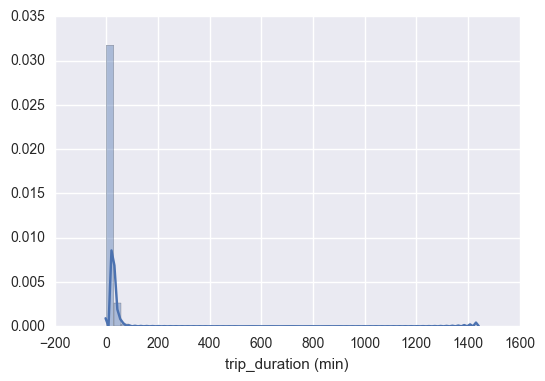

In [563]:
sns.distplot(train['trip_duration'][:100000]/60/60)
plt.xlabel("trip_duration (min)")

The shortest trip takes only 1s. This is really weired.
And the longest trip takes more than 979.5 hours. This is really crazy!
We can observed that there're definatly outliers in our dataset.
Leaving them alone can skew our models. Why not eliminate them now?

For the trips that are too short:<br>
It is hard to define how short is considered as "too short". Here, we eliminate the trips that are smaller than 30s.
For the trips that are too long:<br>
We clear the outliers here by deleting the trip that is more than 2 standard deviation.<br>
(You are free to pick smaller or larger threshold!)<br>
Note: Thanks [NYCT - from A to Z with XGBoost (Tutorial)](https://www.kaggle.com/karelrv/nyct-from-a-to-z-with-xgboost-tutorial/notebook) for giving me inspiration of cleaning outliers.

In [566]:
mean = np.mean(train['trip_duration'])
std = np.std(train['trip_duration'])
print(train[train['trip_duration']>=(mean + 2*std)]['id'].count(), "data is counted as large outliers.")
print(train[train['trip_duration']<=30]['id'].count(), "data is counted as small outliers.")

2104 data is counted as large outliers.
4890 data is counted as small outliers.


In [567]:
train = train[train['trip_duration']<=(mean + 2*std)]
train = train[train['trip_duration']>30]

In [568]:
print("We now have", train.shape[0], "samples in our training data.")

We now have 1451650 samples in our training data.


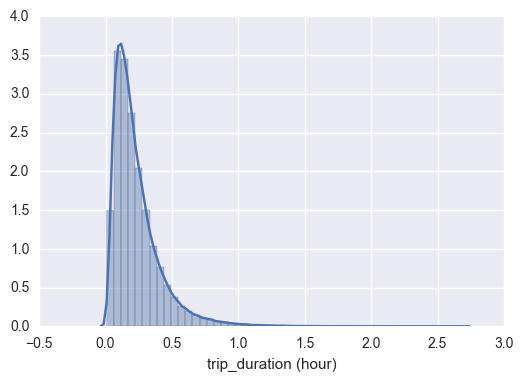

In [570]:
sns.distplot(train['trip_duration'][:100000]/60/60)
plt.xlabel("trip_duration (hour)")

In [573]:
print("Minimum value in trip_duration is", min(train['trip_duration']), "seconds")
print("Maximum value in trip_duration is", max(train['trip_duration'])/60/60, "hours")

Minimum value in trip_duration is 31 seconds
Maximum value in trip_duration is 3.16972222222 hours


Cheers! We've finish data preprocessing! Let's get into next part: Feature Engineering!

---

## Feature engineering
We only have 11 features in this competition, and some of them cannot be used directly, eg. time series, location information. We thus have to do some feature engineering to generate features from existing features.

### Timestamp
Though we have only two columns that are related to time, we can actually do some feature engineering to get a lot more features from these two columns. For those who is new to pandas datetime, you can watch [this](https://www.youtube.com/watch?v=yCgJGsg0Xa4) 10 min video of introducing how to work with dates and times in pandas. Also, if you want to see all attributes of datetime, go to [pandas API reference](https://pandas.pydata.org/pandas-docs/stable/api.html), and search for ".dt.".

#### Converting into pandas datetime
In pandas document ([pandas.Series.dt](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.dt.html)), it says that if a series is **datetimelike**, then it has a .dt properties. The origin type of datetime columns are object. Let's first convert it into pandas datetime.

In [574]:
# Before converting, the datetime columns have type object.
train[['pickup_datetime', 'dropoff_datetime']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451650 entries, 0 to 1458643
Data columns (total 2 columns):
pickup_datetime     1451650 non-null object
dropoff_datetime    1451650 non-null object
dtypes: object(2)
memory usage: 33.2+ MB


In [575]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

In [576]:
train[['pickup_datetime', 'dropoff_datetime']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451650 entries, 0 to 1458643
Data columns (total 2 columns):
pickup_datetime     1451650 non-null datetime64[ns]
dropoff_datetime    1451650 non-null datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 33.2 MB


After converting, we can see that the type has changed into datetime.

#### Generating new features
We do some feature engineering using the pickup_datetime column.
We're not using dropoff_datetime since it is not available in out testing dataset.

In [577]:
# date and dayofyear are actually similar, except for the way that they represent each day.
# For instance, January 1st in date and dayofyear represent Jan, 1 and 1 respectively.
# date is easiler for readers to interpret while dayofyear is suitable for being a feature.
# Thus we use date for ploting and dayofyear for training models.
train['pickup_date'] = train['pickup_datetime'].dt.date # April, 1
train['pickup_dayofyear'] = train['pickup_datetime'].dt.dayofyear # 1~365
train['pickup_month'] = train['pickup_datetime'].dt.month # 1~12
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday # 0~6
train['pickup_hour'] = train['pickup_datetime'].dt.hour # 0~23 hr

test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_dayofyear'] = test['pickup_datetime'].dt.dayofyear
test['pickup_month'] = test['pickup_datetime'].dt.month
test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
test['pickup_hour'] = test['pickup_datetime'].dt.hour

#### Visualizing traffic flow
We're curious about the traffic flow for each day, week, month and even a whole year.
So why not visualize them?

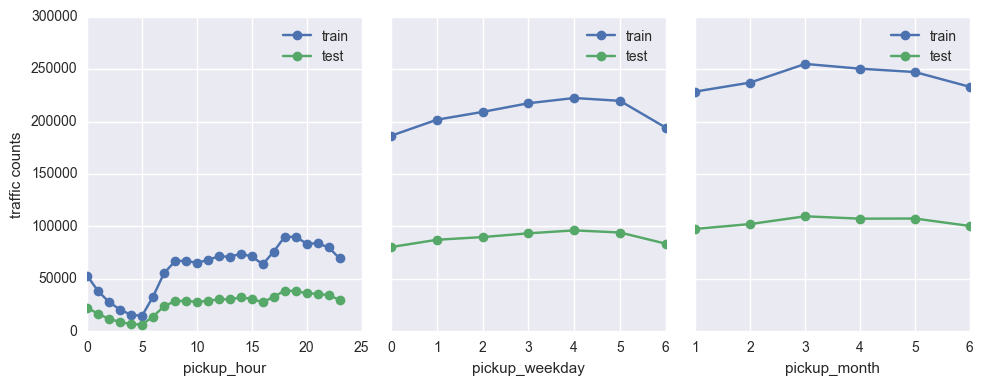

In [578]:
group_list = ['pickup_hour', 'pickup_weekday', 'pickup_month']
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(10, 4))
ax[0].set_ylabel('traffic counts')
for index, value in enumerate(group_list):
    ax[index].plot(train.groupby(value).count()['id'], 'o-', label='train')
    ax[index].plot(test.groupby(value).count()['id'], 'o-', label='test')
    ax[index].set_xlabel(value)
    ax[index].legend()
plt.tight_layout()

From the plots above, we can observe that there's actually rush hours, weekdays and months with more traffic.
We can expect that when the traffic is heavy, it takes longer for a taxi to drive from one place to another.

Next, we take a closer look at the daily traffic.

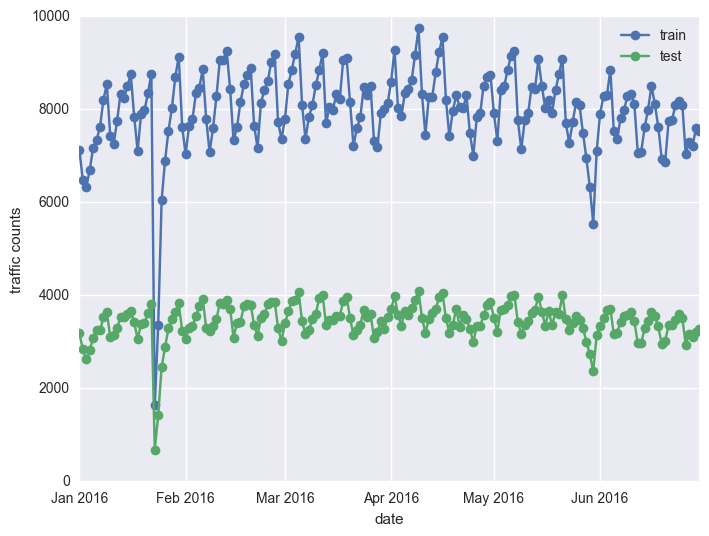

In [579]:
plt.figure(figsize=(8, 6))
plt.plot(train.groupby('pickup_date').count()['id'], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()['id'], 'o-', label='test')
plt.xlabel("date")
plt.ylabel("traffic counts")
plt.legend()

It seems that traffic in both training and testing are similar.

### Handling locational information
#### Inspecting region
From the title of this competition, we can know that the dataset is collected from the taxik in New York.
Let's see which region of New York does most of the traffic occurs.

(40.63, 40.85)

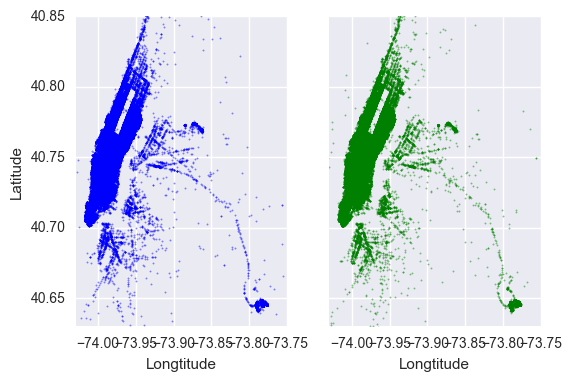

In [580]:
N = 100000
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
ax[0].scatter(train["pickup_longitude"].values[:N], train["pickup_latitude"].values[:N], s=1, color='b', alpha=0.4)
ax[0].set_xlabel("Longtitude")
ax[0].set_ylabel("Latitude")
ax[1].scatter(test["pickup_longitude"].values[:N], test["pickup_latitude"].values[:N], s=1, color='g', alpha=0.4)
ax[1].set_xlabel("Longtitude")
plt.xlim(city_long_border)
plt.ylim(city_lat_border)

From the plots above, we can know that most of the traffic in this dataset happens in Manhattan.
We can also observe that the region of training and testing dataset are actually overlapped. Great!

#### The Map of Manhattan
Speaking of Manhattan, why not take a look at the map of Manhattan?

In [581]:
map_osm = folium.Map(location=[40.78, -73.85], zoom_start=12)
map_osm

#### Cluster based on longtitude & latitude
The model may not perform that well with only longtitude and latitude information. We may have to transform the locational information into something more meaningful. Doing clustering and separating regions into different groups sounds like a good idea.

Because of the large datasets, we use MiniBatchKMeans here instead of KMeans to reduce the training time.

In [582]:
from sklearn.cluster import MiniBatchKMeans

In [583]:
longtitude = train['pickup_longitude'].tolist() + train['dropoff_longitude'].tolist()
latitude = train['pickup_latitude'].tolist() + train['dropoff_latitude'].tolist()
location_df = pd.DataFrame({"longtitude":longtitude, "latitude":latitude})

We pick 10 clusters here. You can try other numbers of clusters.

In [584]:
n_clusters = 10
start = time.time()
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=2)
kmeans.fit(location_df)
end = time.time()
print("It takes", (end-start), "seconds to train a MiniBatchKMeans.")

It takes 4.4588611125946045 seconds to train a MiniBatchKMeans.


After training KMeans model, we get the labels for each data.

In [585]:
location_df['labels'] = kmeans.labels_

In [586]:
location_df.head()

,latitude,longtitude,labels
0,40.767937,-73.982155,0
1,40.738564,-73.980415,2
2,40.763939,-73.979027,0
3,40.719971,-74.010040,6
4,40.793209,-73.973053,7


Let's inspecting the locational information again. This time, coloring the points with different labels.

(40.63, 40.85)

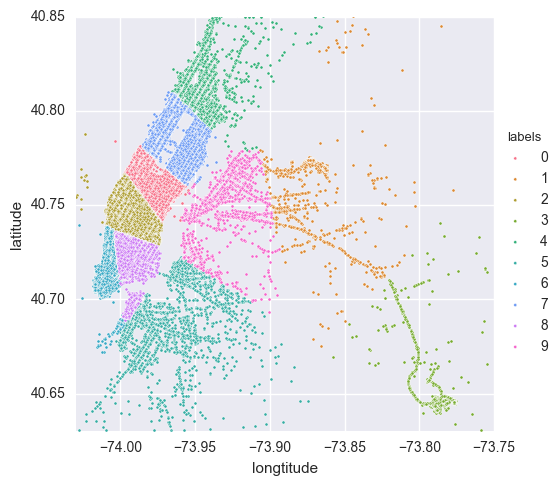

In [587]:
N = 300000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
sns.pairplot(x_vars=['longtitude'], y_vars=['latitude'], data=location_df.loc[:N,:],
             hue='labels', size=5, aspect=1, plot_kws={"s": 5})
plt.xlim(city_long_border)
plt.ylim(city_lat_border)

Great! It seems that our model performs pretty well.
Next, we create two columns to store the labels as features.

In [588]:
train_pickup = pd.concat((train['pickup_latitude'], train['pickup_longitude']), axis=1)
train_drop = pd.concat((train['dropoff_latitude'], train['dropoff_longitude']), axis=1)
test_pickup = pd.concat((test['pickup_latitude'], test['pickup_longitude']), axis=1)
test_drop = pd.concat((test['dropoff_latitude'], test['dropoff_longitude']), axis=1)
train_plabels = kmeans.predict(train_pickup)
train_dlabels = kmeans.predict(train_drop)
test_plabels = kmeans.predict(test_pickup)
test_dlabels = kmeans.predict(test_drop)

In [589]:
train['plabels'] = train_plabels 
train['dlabels'] = train_dlabels
test['plabels'] = test_plabels
test['dlabels'] = test_dlabels

The labels get from kmeans do not have any numerical meaning. As a result, instead of the origin numerical type, we transform the type into object (string-like).

In [590]:
train['plabels'] = train['plabels'].astype(object)
train['dlabels'] = train['dlabels'].astype(object)
test['plabels'] = test['plabels'].astype(object)
test['dlabels'] = test['dlabels'].astype(object)

### Calculate the distance

With locational information, we can also calculate the distance between origin and destination.
Notice that the origin haversine library in python does not work well with numpy array. Thus we custom one by ourselves using numpy.

In [591]:
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

In [592]:
train['distance'] = haversine_(train['pickup_latitude'].values, train['pickup_longitude'].values,
                              train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test['distance'] = haversine_(test['pickup_latitude'].values, test['pickup_longitude'].values,
                             test['dropoff_latitude'].values, test['dropoff_longitude'].values)

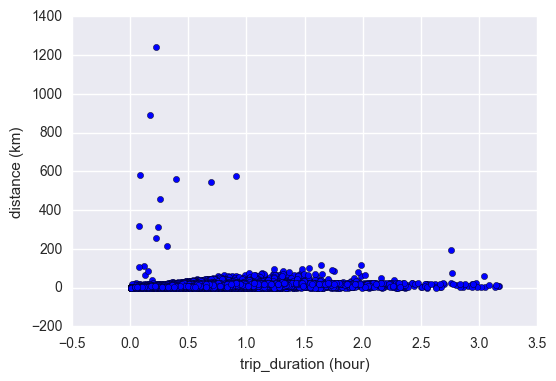

In [593]:
plt.scatter(train['trip_duration']/60/60, train['distance'])
plt.xlabel("trip_duration (hour)")
plt.ylabel("distance (km)")

In [598]:
min_distance = min(train['distance'])
print("The minimum distance of all the trips is", min_distance, "km.")
print("There are", train[train['distance']==min_distance]['id'].count(), "trips that the distance is", min_distance, "km.")

The minimum distance of all the trips is 0.0 km.
There are 4545 trips that the distance is 0.0 km.


0km? This sounds really weired! We count them as mis-recorded trips!

In [599]:
train = train[train['distance'] > 0]
print("After clearning,", train.shape[0], "samples remain.")

After clearning, 1447105 samples remain.


With distance information, we can also check the speed of the taxik.

In [600]:
# compute speed in hours
train['speed'] = train['distance'] / (train['trip_duration']/60/60)

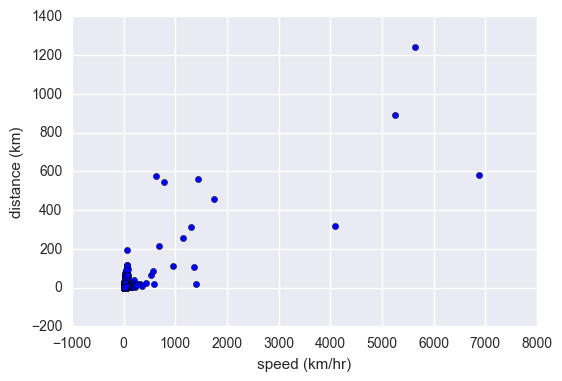

In [601]:
plt.scatter(train['speed'], train['distance'])
plt.xlabel("speed (km/hr)")
plt.ylabel("distance (km)")

New York top speed is 65 mph, which is around 100 kph.
So here, we eliminate the trips which speed are faster than 100 kph.

In [602]:
print(train[train['speed'] > 100]['id'].count(), "trips have speed exceeding 100 kph.")
train = train[train['speed']<=100]
print("After deleting outliers,", train.shape[0], "samples remain.")

60 trips have speed exceeding 100 kph.
After deleting outliers, 1447045 samples remain.


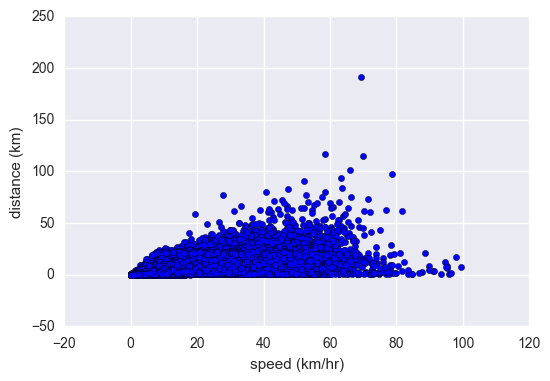

In [603]:
plt.scatter(train['speed'], train['distance'])
plt.xlabel("speed (km/hr)")
plt.ylabel("distance (km)")

Speed in some extends represents traffic flow. The slower the speed is, the heavier the traffic is.

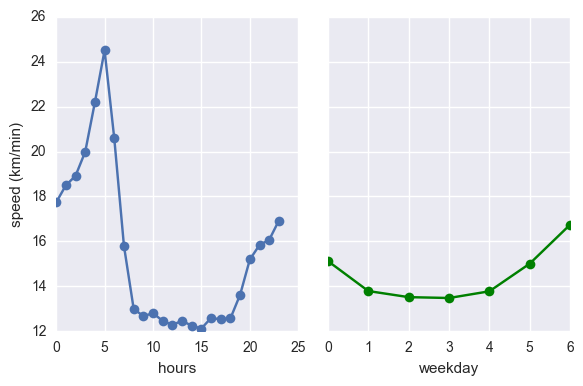

In [604]:
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].set_xlabel("hours")
ax[0].set_ylabel("speed (km/min)")
ax[1].set_xlabel("weekday")
ax[0].plot(train.groupby('pickup_hour')['speed'].mean(), 'o-')
ax[1].plot(train.groupby('pickup_weekday')['speed'].mean(), 'o-', color='green')
plt.tight_layout()

We can observe that in rush hours (around 7 ~ 19 o'clock), the traffic is way heavier than early morning.
While on Friday and weekend, the traffic is ralatively light.

### Passenger count


## TODO


We can see that most people tend to take the taxi only by themselves.
And those records with 0 passenger may imply the taxi driver drive to drive the passengers. (quick tongue twisting, lol.)

In [605]:
train['passenger_count'].value_counts()

1    1025165
2     208843
5      77476
3      59492
6      47876
4      28172
0         21
Name: passenger_count, dtype: int64

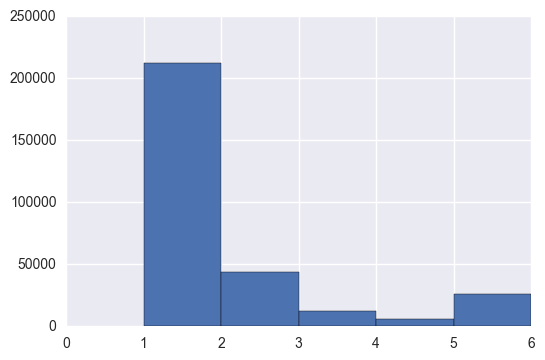

In [606]:
N = 300000
_ = plt.hist(train['passenger_count'][:N], bins=6)

We want to know the relationship between distance and passenger_count.

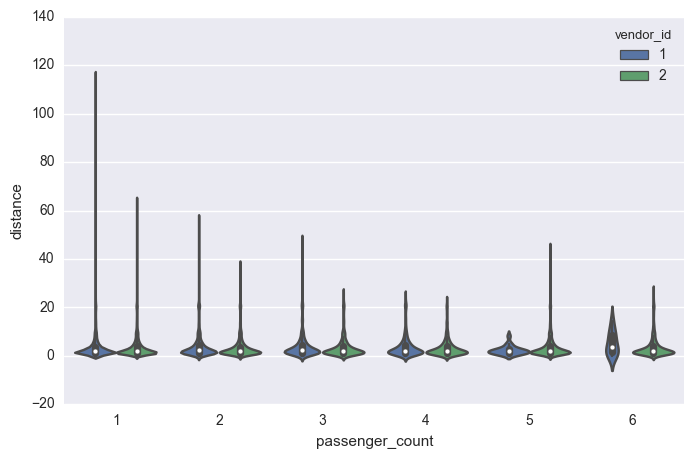

In [607]:
N = 100000
plt.figure(figsize=(8, 5))
sns.violinplot(x='passenger_count', y='distance', hue='vendor_id', data=train[:N])

We can see that most of the taxi with single passenger tends to go to further place.

### Vendor_id

We expect that taxik with same vendor_id will have similar attribute.

In [608]:
count_vendor = train.groupby('vendor_id')['id'].count()
print("vendor_id 1 has", count_vendor.get(1), "data, while vendor_id 2 has", count_vendor.get(2), "data.")

vendor_id 1 has 673987 data, while vendor_id 2 has 773058 data.


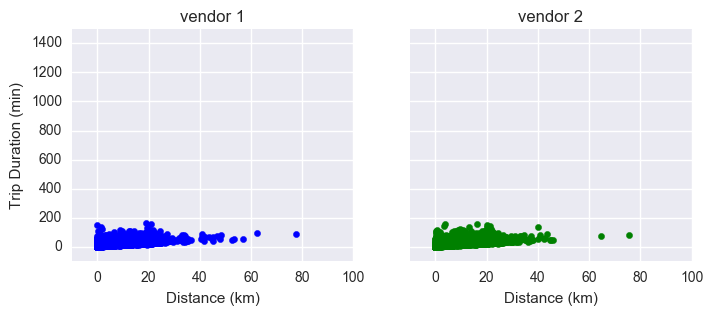

In [611]:
N = 100000
fig, ax = plt.subplots(ncols=2, figsize=(8, 3), sharex=True, sharey=True)
vendor_1 = train[train['vendor_id']==1]
vendor_2 = train[train['vendor_id']==2]
ax[0].set_title("vendor 1")
ax[0].set_xlim(-10, 100)
ax[0].set_ylim(-100, 1500)
ax[0].set_xlabel("Distance (km)")
ax[0].set_ylabel("Trip Duration (min)")
ax[1].set_title("vendor 2")
ax[1].set_xlabel("Distance (km)")
ax[0].scatter(vendor_1['distance'][:N], vendor_1['trip_duration'][:N]/60, color='blue')
ax[1].scatter(vendor_2['distance'][:N], vendor_2['trip_duration'][:N]/60, color='green')

### store_and_fwd_flag

At the begining of this notebook, we assume that store_and_fwd_flag may not contribute to the model.
Instead of directly getting rid of this feature, we take a closer look at it.

In [613]:
print("In training file:")
print(train['store_and_fwd_flag'].value_counts())
print("In testing file:")
print(test['store_and_fwd_flag'].value_counts())

In training file:
N    1439133
Y       7912
Name: store_and_fwd_flag, dtype: int64
In testing file:
N    621704
Y      3430
Name: store_and_fwd_flag, dtype: int64


The origin value in 'store_and_fwd_flag' is Y & N.
We do some converting here to help us work easier with this feature.

In [614]:
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].replace({"Y": 1, "N":0})
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].replace({"Y": 1, "N":0})

Let's check if 'store_and_fwd_flag' has any relationship with vendor_id.

In [615]:
print("In training file:")
print(train.groupby('vendor_id')['store_and_fwd_flag'].sum())
print("In testing file:")
print(test.groupby('vendor_id')['store_and_fwd_flag'].sum())

In training file:
vendor_id
1    7912
2       0
Name: store_and_fwd_flag, dtype: int64
In testing file:
vendor_id
1    3430
2       0
Name: store_and_fwd_flag, dtype: int64


It seems that in both training and testing file, only vendor_id 1 has store_and_fwd_flag!
This also means that we can safely delete this feature, since it can be represented by the vendor_id.

In [616]:
train.drop('store_and_fwd_flag', axis=1, inplace=True)
test.drop('store_and_fwd_flag', axis=1, inplace=True)

In [617]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_date,pickup_dayofyear,pickup_month,pickup_weekday,pickup_hour,plabels,dlabels,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,2016-03-14,74,3,0,17,0,0,1.498521,11.856428
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,2016-06-12,164,6,6,0,2,8,1.805507,9.803659
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,2016-01-19,19,1,1,11,0,6,6.385098,10.822201
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,2016-04-06,97,4,2,19,6,6,1.485498,12.465721
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,2016-03-26,86,3,5,13,7,7,1.188588,9.836594


### Transforming trip_duration
We see how trip_duration data distributed.

Skewness: 2.3277984848421345


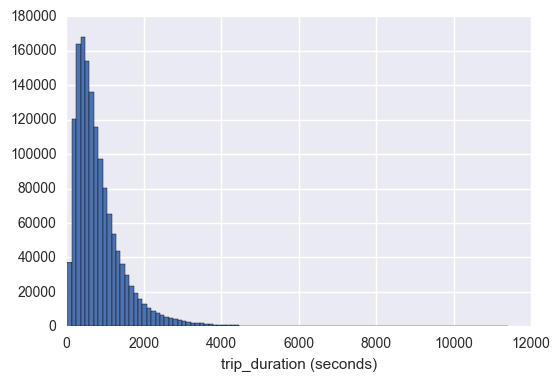

In [620]:
print("Skewness:", skew(train['trip_duration']))
plt.xlabel("trip_duration (seconds)")
_ = plt.hist(train['trip_duration'], bins=100)

Since trip_duration is severely right skewed, we do log transform here.

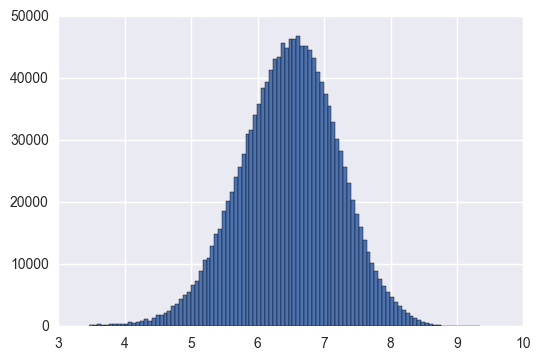

In [621]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
_ = plt.hist(train['log_trip_duration'], bins=100)

### Selecting the features!
Last step toward finishing preprocessing, congrats! 
In this section, we select the features that we want and create feature vector X and predictions y for training a model.

Let's inspect our data again.

In [622]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_date,pickup_dayofyear,pickup_month,pickup_weekday,pickup_hour,plabels,dlabels,distance,speed,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,2016-03-14,74,3,0,17,0,0,1.498521,11.856428,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,2016-06-12,164,6,6,0,2,8,1.805507,9.803659,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,2016-01-19,19,1,1,11,0,6,6.385098,10.822201,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,2016-04-06,97,4,2,19,6,6,1.485498,12.465721,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,2016-03-26,86,3,5,13,7,7,1.188588,9.836594,6.077642


In [623]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'pickup_date',
       'pickup_dayofyear', 'pickup_month', 'pickup_weekday', 'pickup_hour',
       'plabels', 'dlabels', 'distance', 'speed', 'log_trip_duration'],
      dtype='object')

Selecting the columns that we're going to use as features.

In [624]:
selected_columns = ['vendor_id', 'passenger_count', 'pickup_latitude', 'pickup_longitude', 
                    'dropoff_latitude', 'dropoff_longitude', 'pickup_dayofyear', 'pickup_month',
                    'pickup_weekday', 'pickup_hour', 'distance', 'plabels', 'dlabels']
#                    'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1']
X = train[selected_columns]
y = train['log_trip_duration']
test_data = test[selected_columns]

For the object type features, we create dummy variables for them.

In [625]:
X = pd.get_dummies(X, drop_first=True)
test_data = pd.get_dummies(test_data, drop_first=True)

Let's take a final look at out dataset.

In [626]:
X.head()

,vendor_id,passenger_count,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_dayofyear,pickup_month,pickup_weekday,pickup_hour,...,plabels_9,dlabels_1,dlabels_2,dlabels_3,dlabels_4,dlabels_5,dlabels_6,dlabels_7,dlabels_8,dlabels_9
0,2,1,40.767937,-73.982155,40.765602,-73.964630,74,3,0,17,...,0,0,0,0,0,0,0,0,0,0
1,1,1,40.738564,-73.980415,40.731152,-73.999481,164,6,6,0,...,0,0,0,0,0,0,0,0,1,0
2,2,1,40.763939,-73.979027,40.710087,-74.005333,19,1,1,11,...,0,0,0,0,0,0,1,0,0,0
3,2,1,40.719971,-74.010040,40.706718,-74.012268,97,4,2,19,...,0,0,0,0,0,0,1,0,0,0
4,2,1,40.793209,-73.973053,40.782520,-73.972923,86,3,5,13,...,0,0,0,0,0,0,0,1,0,0


In [627]:
test_data.head()

,vendor_id,passenger_count,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_dayofyear,pickup_month,pickup_weekday,pickup_hour,...,plabels_9,dlabels_1,dlabels_2,dlabels_3,dlabels_4,dlabels_5,dlabels_6,dlabels_7,dlabels_8,dlabels_9
0,1,1,40.732029,-73.988129,40.756680,-73.990173,182,6,3,23,...,0,0,1,0,0,0,0,0,0,0
1,1,1,40.679993,-73.964203,40.655403,-73.959808,182,6,3,23,...,0,0,0,0,0,1,0,0,0,0
2,1,1,40.737583,-73.997437,40.729523,-73.986160,182,6,3,23,...,0,0,0,0,0,0,0,0,1,0
3,2,1,40.771900,-73.956070,40.730469,-73.986427,182,6,3,23,...,0,0,0,0,0,0,0,0,1,0
4,1,1,40.761475,-73.970215,40.755890,-73.961510,182,6,3,23,...,0,0,0,0,0,0,0,0,0,0


In [628]:
y.head()  # Don't forget to take exponential to get the real time_duration.

0    6.122493
1    6.498282
2    7.661527
3    6.063785
4    6.077642
Name: log_trip_duration, dtype: float64

Feel free to skip the step below, if you don't want to save the preprocessed data.

In [629]:
train_preprocessed = pd.concat([train['id'], X, y], axis=1)
train_preprocessed.to_csv("preprocessed_train.csv", index=False)
test_preprocessed = pd.concat([test['id'], test_data], axis=1)
test_preprocessed.to_csv("preprocessed_test.csv", index=False)

Good, now everything seems to work fine. We can start building our models with these wonderful features!

---

## Model
We select xgboost as out model (just like what most kagglers do).

In [463]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.svm import SVR
import xgboost as xgb
import os

In [ ]:
def RMSE(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [398]:
def submission(file_name, _id, prediction):
    path = os.path.join('submission', file_name)
    prediction = np.exp(prediction) + 1
    df = pd.DataFrame({"id":_id,"trip_duration":prediction})
    df.to_csv(path, index=False)

### cross-validation vs train-test-split
Both cross-validation and train-test-split are useful tools in tunning the model's parameters.
Usually, cross-validation performs better than train-test-split since it tries several set (k-fold cross-validation) of combination of training and testing data. However, this is a time-performance trade off. If the dataset or feature vector is large, it may requires much more time to train a model using cross-validation. So in this competition, which has a lot of dataset, we use train-test-split instead.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### parameters tunning
These are the parameters I've tried to tune beforehead. Default parameters are used as baseline of the model.
- max_depth
- min_child_weight
- gamma
- subsample
- colsample_bytree
- reg_alpha
- learning_rate
- n_estimators

We start by tuning the max_depth of xgboost first.

In [ ]:
# loss = [RMSE_cv(xgb.XGBRegressor(max_depth=i), X, y) for i in range(3, 11)]

In [464]:
# Tuning parameters
now = time.time()
xgb_model = xgb.XGBRegressor(max_depth=10, min_child_weight=5, gamma=0.0, subsample=1, colsample_bytree=1,
                             learning_rate=0.05, n_estimators=200)
xgb_model.fit(X, y)
end = time.time()
print("It takes", (end-now), "to train a xgboost.")

KeyboardInterrupt: 

In [465]:
y_pred = xgb_model.predict(test_data)
submission("xgb_submission.csv", test['id'], y_pred)

XGBoostError: need to call fit beforehand

Current best score: one-hot(10 cluster) + longtitude + latitude
Current: 20 cluster (one-hot) + longtitude + latitude